# Book-Oracle

Book-Oracle is a book recommendation app which suggest books based on preferences.

## Import Libraries

In [2]:
import pandas as pd
import numpy as np

#Modelling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

#NLP
import nltk

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = "{:,.2f}".format

#Custom functions
from utils.data_cleaning import clean_ratings, clean_users, clean_books

RSEED = 42

import warnings
warnings.filterwarnings('ignore')

## Import Data

In [3]:
ratings_df = pd.read_csv('data/ratings.csv')
books_df = pd.read_csv('data/books.csv')
users_df = pd.read_csv('data/users.csv')

print("Ratings table has {} rows and {} columns".format(ratings_df.shape[0], ratings_df.shape[1]))
print("Books table has {} rows and {} columns".format(books_df.shape[0], books_df.shape[1]))
print("Users table has {} rows and {} columns".format(users_df.shape[0], users_df.shape[1]))

Ratings table has 1149780 rows and 3 columns
Books table has 271360 rows and 8 columns
Users table has 278858 rows and 3 columns


## Data cleaning

#### Clean Books Dataset

In [4]:
books_df, common_identifier_dict = clean_books(books_df)

print("Books table has {} rows and {} columns".format(books_df.shape[0], books_df.shape[1]))

Columns and their data types:
book_title             object
book_author            object
year_of_publication    object
publisher              object
image_url_m            object
common_identifier       int64
dtype: object
Books table has 239094 rows and 6 columns


In [5]:
books_df.head(3)

,book_title,book_author,year_of_publication,publisher,image_url_m,common_identifier
0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,1
1,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,2
2,Decision In Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,3


#### Clean Ratings Dataset

In [6]:
ratings_df = clean_ratings(ratings_df)

#assign common identifier and convert to int
ratings_df['common_identifier'] = ratings_df['isbn'].map(common_identifier_dict)

print("Ratings table has {} rows and {} columns".format(ratings_df.shape[0], ratings_df.shape[1]))

#check how many rows in ratings_df do not have a common identifier in books_df
print("")
print("There are {} rows in ratings_df that do not have a common identifier in books_df".format(ratings_df[~ratings_df['common_identifier'].isin(books_df['common_identifier'])].shape[0]))

ratings_df.sort_values(by="common_identifier", ascending=True).head(3)

Columns and their data types:
user_id         int64
isbn           object
book_rating     int64
dtype: object

Number of duplicated rows:0

Number of rows with missing values:0
Ratings table has 1149780 rows and 4 columns

There are 118646 rows in ratings_df that do not have a common identifier in books_df


,user_id,isbn,book_rating,common_identifier
9561,2,0195153448,0,1.00
1125456,269782,0801319536,7,1.00
188244,41385,0002005018,0,2.00


#### Clean Users Dataset

In [7]:
users_df = clean_users(users_df)

print("Users table has {} rows and {} columns".format(users_df.shape[0], users_df.shape[1]))
users_df.head(3)

Columns and their data types:
user_id     int64
age         int64
city       object
country    object
dtype: object
Users table has 275565 rows and 4 columns


,user_id,age,city,country
0,1,0,new york,usa
1,2,18,stockton,usa
2,3,0,moscow,russia


## Merge tables

In [8]:
#Merge all tables
df = books_df.merge(ratings_df, on='common_identifier', how='inner')
df = df.merge(users_df, on='user_id', how='inner')

#check for missing values
print("There are {} missing values in df".format(df.isnull().sum().sum()))

#check for duplicates
print("There are {} duplicates in df".format(df.duplicated().sum()))

df.head(3)

There are 0 missing values in df
There are 0 duplicates in df


,book_title,book_author,year_of_publication,publisher,image_url_m,common_identifier,user_id,isbn,book_rating,age,city,country
0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,1,2,0195153448,0,18,stockton,usa
1,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,1,269782,0801319536,7,30,edmonton,canada
2,Pay It Forward: A Novel,Catherine Ryan Hyde,2000,Simon &amp; Schuster,http://images.amazon.com/images/P/0684862719.0...,2392,269782,0684862719,8,30,edmonton,canada


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005487 entries, 0 to 1005486
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   book_title           1005487 non-null  object
 1   book_author          1005487 non-null  object
 2   year_of_publication  1005487 non-null  object
 3   publisher            1005487 non-null  object
 4   image_url_m          1005487 non-null  object
 5   common_identifier    1005487 non-null  int64 
 6   user_id              1005487 non-null  int64 
 7   isbn                 1005487 non-null  object
 8   book_rating          1005487 non-null  int64 
 9   age                  1005487 non-null  int64 
 10  city                 1005487 non-null  object
 11  country              1005487 non-null  object
dtypes: int64(4), object(8)
memory usage: 92.1+ MB


## Save cleaned data

In [10]:
df.to_csv('data/kaggle_full_df.csv', index=False)

## Exploratory Data Analysis

In [11]:
#check for outliers
df.describe()

,common_identifier,user_id,book_rating,age
count,"1,005,487.00","1,005,487.00","1,005,487.00","1,005,487.00"
mean,"60,453.72","142,071.70",2.81,27.35
std,"70,317.76","79,702.89",3.85,19.31
min,1.00,2.00,0.00,0.00
25%,"6,498.00","73,651.00",0.00,0.00
50%,"28,649.00","142,565.00",0.00,30.00
75%,"93,607.00","212,216.00",7.00,41.00
max,"271,358.00","278,854.00",10.00,100.00


Percentage of users that come from English speaking countries: 90.13%
Percentage of ratings that are implicit (user interacted with a book, but hasn't given a rating): 63.12%


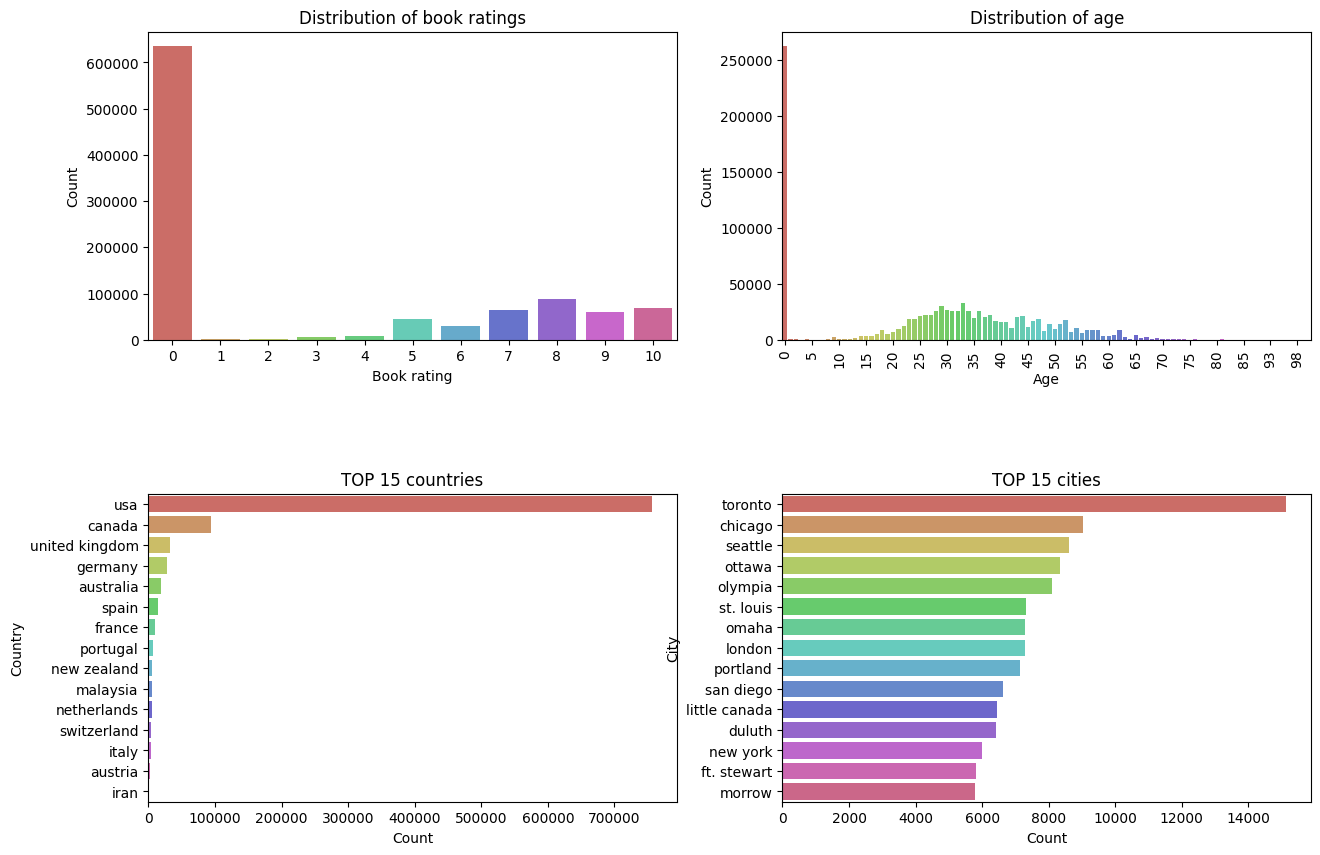

In [12]:
#Book rating distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.countplot(ax=axes[0, 0], x='book_rating', data=df, palette='hls')
axes[0, 0].set_title('Distribution of book ratings')
axes[0, 0].set_xlabel('Book rating')
axes[0, 0].set_ylabel('Count')

#User rating distribution
sns.countplot(ax=axes[0, 1], x='age', data=df, palette='hls')
axes[0, 1].set_title('Distribution of age')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=90)
axes[0, 1].xaxis.set_major_locator(plt.MultipleLocator(5))

#Top 15 countries
sns.countplot(ax=axes[1, 0], y='country', data=df, palette='hls', order=df['country'].value_counts().iloc[:15].index)
axes[1, 0].set_title('TOP 15 countries')
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_ylabel('Country')

#Top 15 cities
sns.countplot(ax=axes[1, 1], y='city', data=df, palette='hls', order=df['city'].value_counts().iloc[:15].index)
axes[1, 1].set_title('TOP 15 cities')
axes[1, 1].set_xlabel('Count')
axes[1, 1].set_ylabel('City')

plt.subplots_adjust(hspace=0.5)

#print percentage of users that come from English speaking countries

print("Percentage of users that come from English speaking countries: {:.2f}%".format(df[df['country'].isin(['usa', 'canada', 'united kingdom', 'australia', 'new zealand', 'ireland'])].shape[0]/df.shape[0]*100))

#print percentage of ratings that are implicit (rating equals 0)

print("Percentage of ratings that are implicit (user interacted with a book, but hasn't given a rating): {:.2f}%".format(df[df['book_rating']==0].shape[0]/df.shape[0]*100))

In [13]:
#% of users that have rated more than 30 books

print("Percentage of users that have rated more than 30 books: {:.2f}%".format(df['user_id'].value_counts()[df['user_id'].value_counts()>30].shape[0]/df['user_id'].value_counts().shape[0]*100))

# % of books that have more than 50 ratings

print("Percentage of books that have more than 50 ratings: {:.2f}%".format(df['common_identifier'].value_counts()[df['common_identifier'].value_counts()>50].shape[0]/df['common_identifier'].value_counts().shape[0]*100))

Percentage of users that have rated more than 30 books: 5.01%
Percentage of books that have more than 50 ratings: 1.00%


In [14]:
#Explore number of books rated per user
print("95% of users have rated {} or less books".format(df['user_id'].value_counts().quantile(0.95)))
print("90% of users have rated {} or less books".format(df['user_id'].value_counts().quantile(0.9)))
print("75% of users have rated {} or less books".format(df['user_id'].value_counts().quantile(0.75)))
print("50% of users have rated {} or less books".format(df['user_id'].value_counts().quantile(0.5)))

#print quantiles of number of book ratings per user
print("Quantiles of number of book ratings per user:")
print(df['user_id'].value_counts().quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

95% of users have rated 31.0 or less books
90% of users have rated 13.0 or less books
75% of users have rated 4.0 or less books
50% of users have rated 1.0 or less books
Quantiles of number of book ratings per user:
0.25     1.00
0.50     1.00
0.75     4.00
0.90    13.00
0.95    31.00
0.99   179.00
Name: count, dtype: float64


In [15]:
#Explore number of ratings per book

print("95% of books have {} or less ratings".format(df['common_identifier'].value_counts().quantile(0.95)))
print("90% of books have {} or less ratings".format(df['common_identifier'].value_counts().quantile(0.9)))
print("75% of books have {} or less ratings".format(df['common_identifier'].value_counts().quantile(0.75)))
print("50% of books have {} or less ratings".format(df['common_identifier'].value_counts().quantile(0.5)))

#print quantiles of number of book ratings per book
print("Quantiles of number of book ratings per book:")
print(df['common_identifier'].value_counts().quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

95% of books have 13.0 or less ratings
90% of books have 7.0 or less ratings
75% of books have 3.0 or less ratings
50% of books have 1.0 or less ratings
Quantiles of number of book ratings per book:
0.25    1.00
0.50    1.00
0.75    3.00
0.90    7.00
0.95   13.00
0.99   51.00
Name: count, dtype: float64


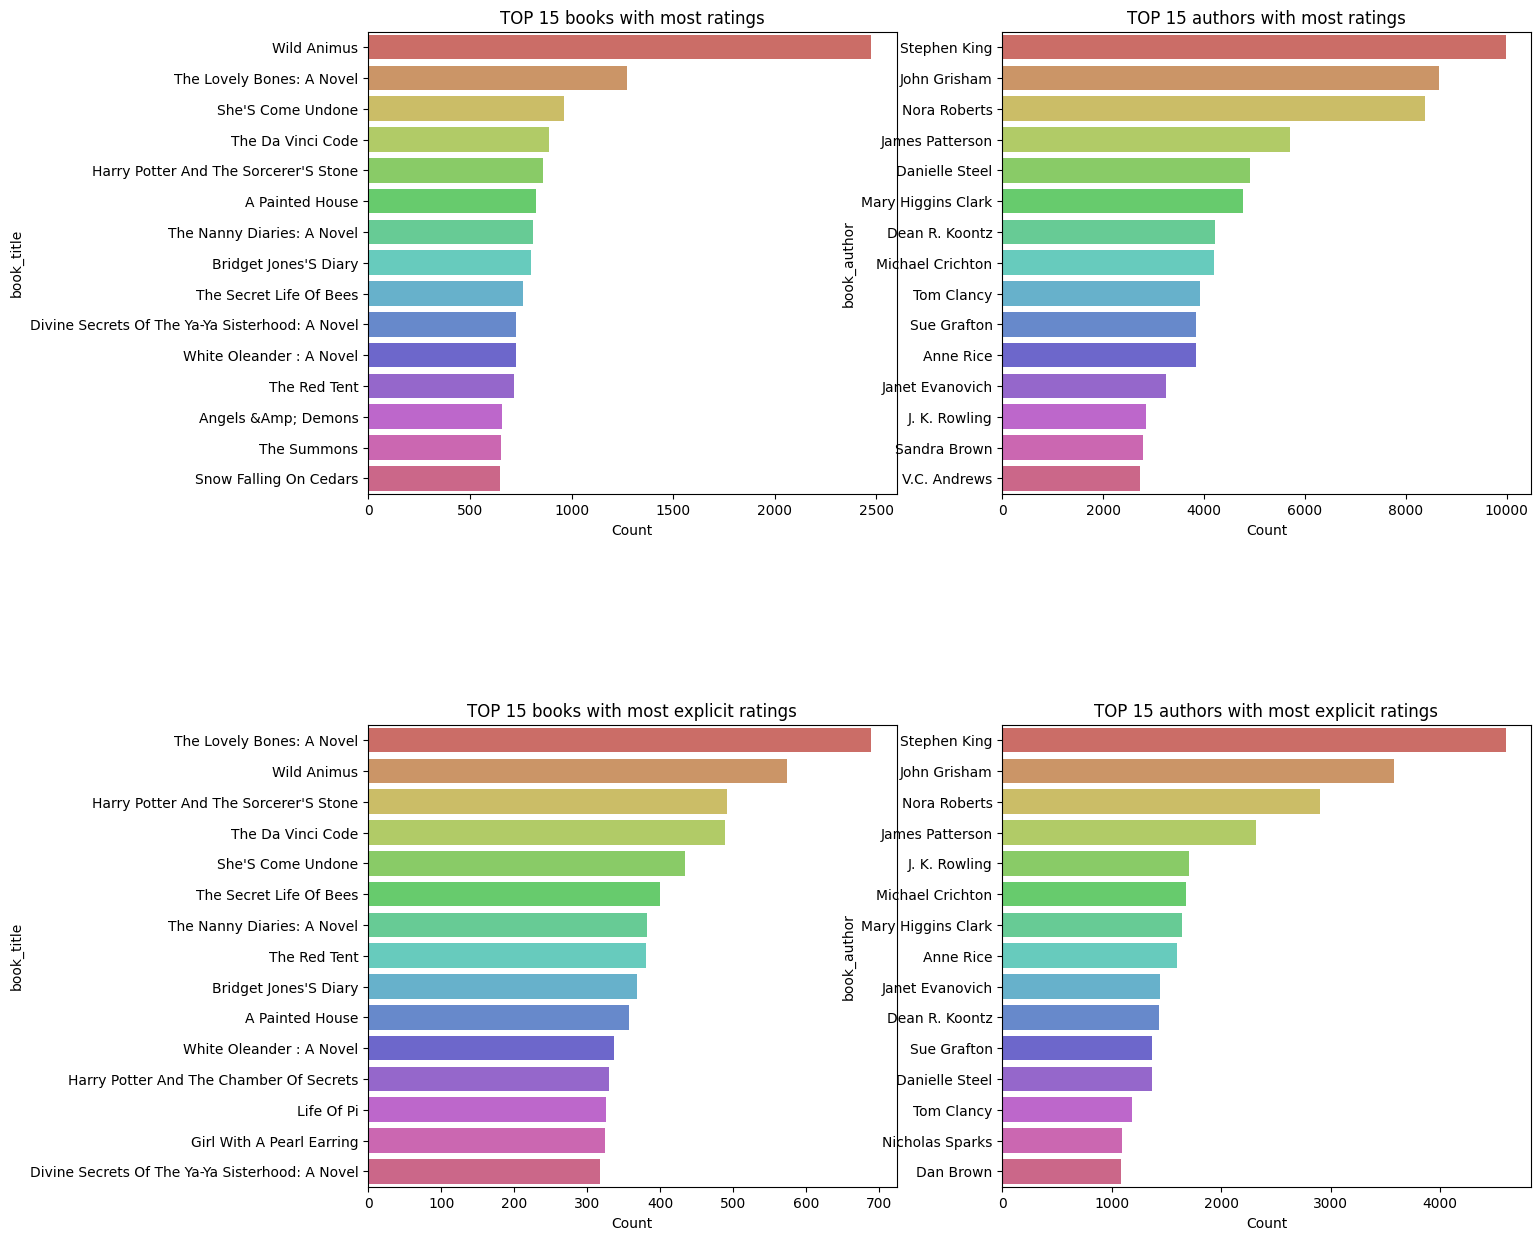

In [16]:
fig,axes = plt.subplots(2, 2, figsize=(15, 15))

#Visualise titles with most ratings
sns.countplot(ax=axes[0, 0], y='book_title', data=df, palette='hls', order=df['book_title'].value_counts().iloc[:15].index)
axes[0, 0].set_title('TOP 15 books with most ratings')
axes[0, 0].set_xlabel('Count')

#Visualise authors with most ratings
sns.countplot(ax=axes[0, 1], y='book_author', data=df, palette='hls', order=df['book_author'].value_counts().iloc[:15].index)
axes[0, 1].set_title('TOP 15 authors with most ratings')
axes[0, 1].set_xlabel('Count')

#Visualise titles with most explicit ratings
sns.countplot(ax=axes[1, 0], y='book_title', data=df[df['book_rating']!=0], palette='hls', order=df[df['book_rating']!=0]['book_title'].value_counts().iloc[:15].index)
axes[1, 0].set_title('TOP 15 books with most explicit ratings')
axes[1, 0].set_xlabel('Count')

#Visualise authors with most explicit ratings, truncate titles above 30 characters
sns.countplot(ax=axes[1, 1], y='book_author', data=df[df['book_rating']!=0], palette='hls', order=df[df['book_rating']!=0]['book_author'].value_counts().iloc[:15].index)
axes[1, 1].set_title('TOP 15 authors with most explicit ratings')
axes[1, 1].set_xlabel('Count')

plt.subplots_adjust(hspace=0.5)

## Pipline Architecture

## Sample Size

## Modelling

## Evaluation

## Error Analysis